<a href="https://colab.research.google.com/github/sneha5678-cmyk/Marketing-research-methods-Sneha-Gupta_Jio-Institute/blob/main/Cox's_Proportional_Hazard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AttributeError: CoxPHFitter has no attribute 'concordance_'

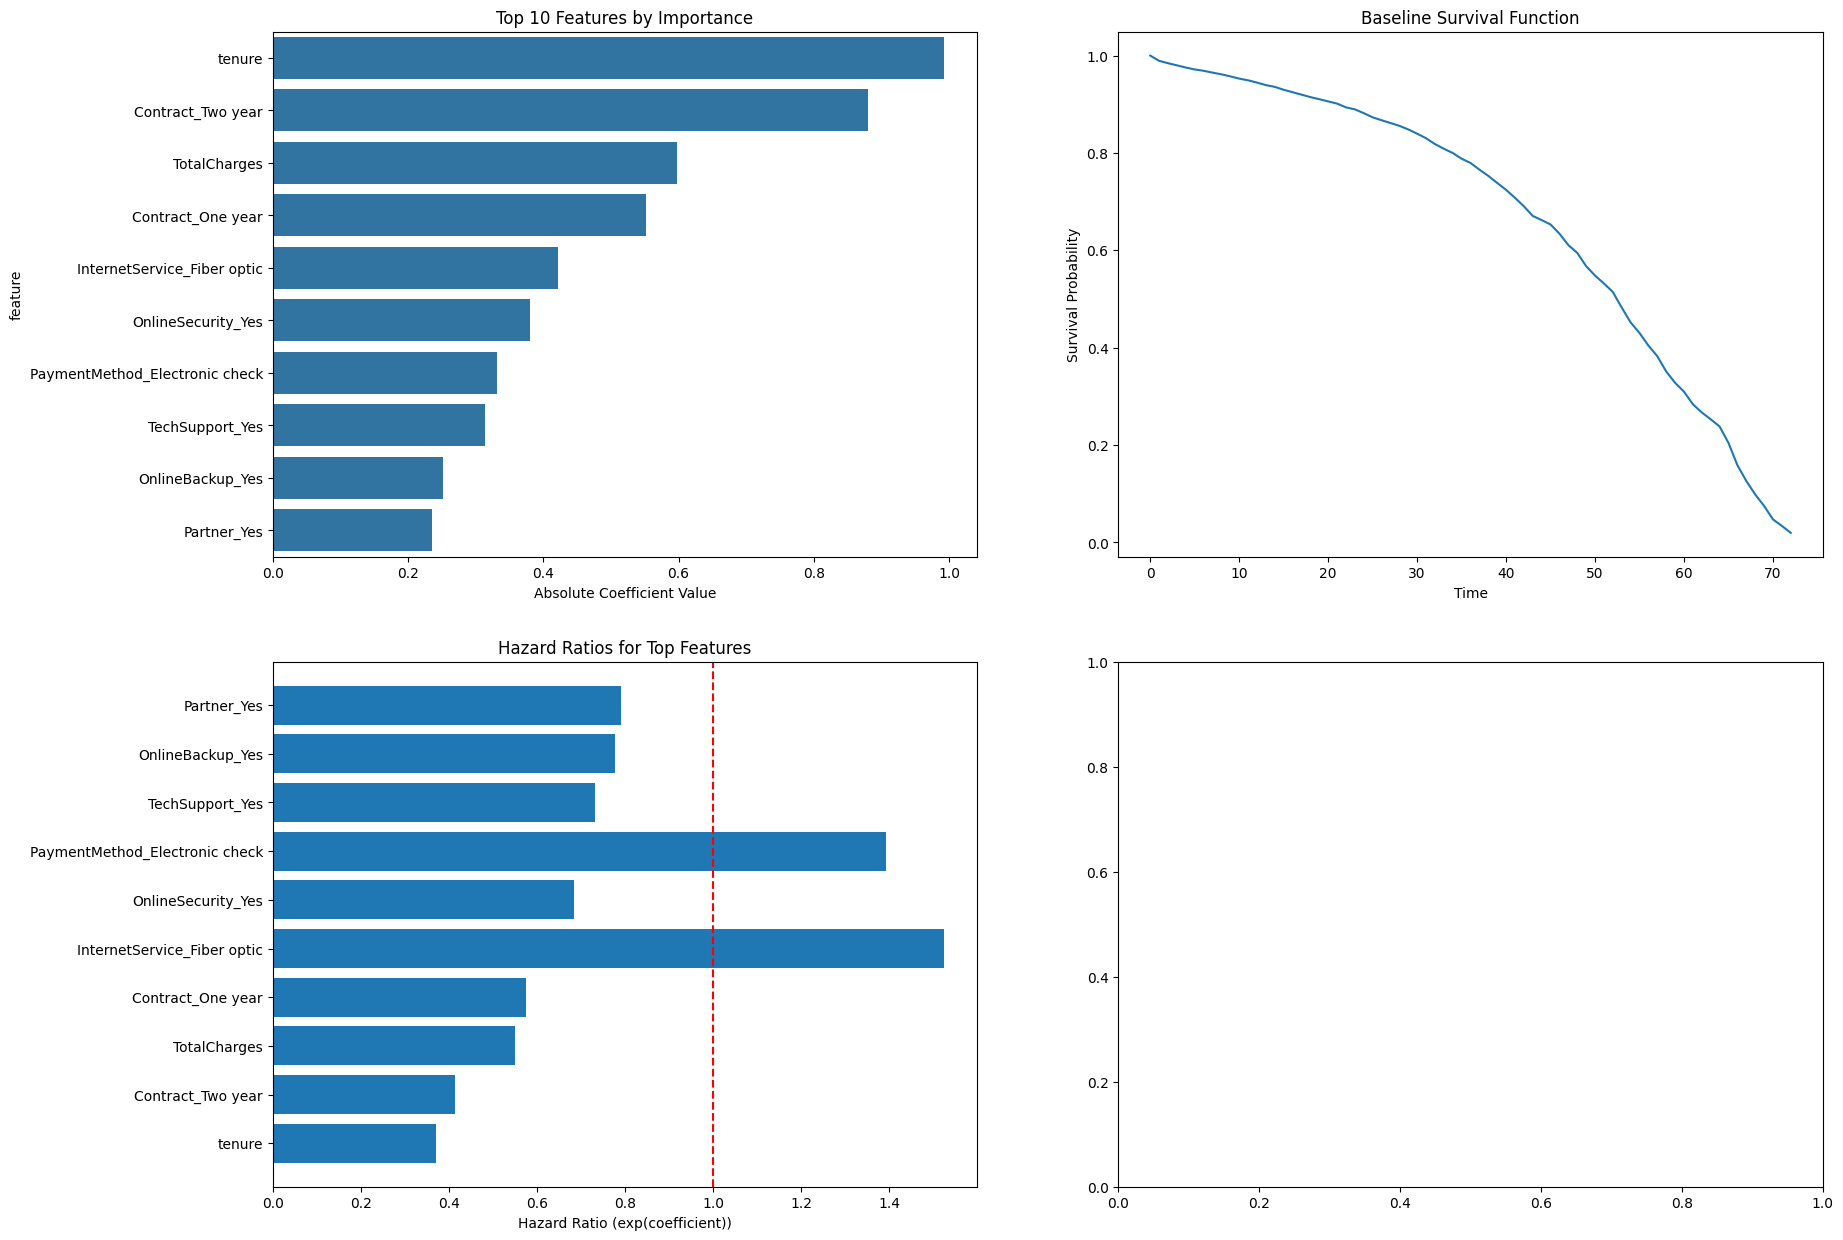

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from lifelines import CoxPHFitter

# Read the dataset
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Data preprocessing
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].str.strip(), errors='coerce')
df['TotalCharges'].fillna(df['MonthlyCharges'], inplace=True)

# Create categorical dummy variables
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                     'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                     'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                     'PaperlessBilling', 'PaymentMethod']

# Create dummy variables
df_dummies = pd.get_dummies(df[categorical_columns], drop_first=True)

# Numerical columns with standardization
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_columns]),
                         columns=numerical_columns)

# Combine scaled numerical and dummy columns
df_final = pd.concat([df_scaled, df_dummies], axis=1)

# Create duration and event columns
df_final['duration'] = df['tenure']
df_final['event'] = (df['Churn'] == 'Yes').astype(int)

# Fit Cox model with penalizer
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_final, duration_col='duration', event_col='event')

# Create figure for visualizations
plt.figure(figsize=(20, 15))

# 1. Feature Importance Plot
plt.subplot(2, 2, 1)
feature_importance = pd.DataFrame({
    'feature': cph.params_.index,
    'coefficient': cph.params_.values,
    'importance': np.abs(cph.params_.values)
})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)
sns.barplot(data=feature_importance, x='importance', y='feature', ax=plt.gca())
plt.title('Top 10 Features by Importance')
plt.xlabel('Absolute Coefficient Value')

# 2. Survival Function
plt.subplot(2, 2, 2)
baseline_survival = cph.baseline_survival_
plt.plot(baseline_survival.index, baseline_survival.values)
plt.title('Baseline Survival Function')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# 3. Hazard Ratio Plot
plt.subplot(2, 2, 3)
hazard_ratios = np.exp(cph.params_)
significant_features = feature_importance['feature']
plt.barh(significant_features, hazard_ratios[significant_features])
plt.title('Hazard Ratios for Top Features')
plt.xlabel('Hazard Ratio (exp(coefficient))')
plt.axvline(x=1, color='r', linestyle='--')

# 4. Model Performance Metrics
plt.subplot(2, 2, 4)
metrics = {
    'Concordance': cph.concordance_,
    'Partial AIC': cph.AIC_,
    'Log-Likelihood Ratio': cph.log_likelihood_ratio_test()[0]
}
plt.text(0.1, 0.7, '\n'.join([f'{k}: {v:.2f}' for k, v in metrics.items()]),
         fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
plt.title('Model Performance Metrics')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print summary of significant features
significant_features = feature_importance[feature_importance['coefficient'] > 0.1]
print("\nTop Significant Features:")
for _, row in significant_features.iterrows():
    print(f"{row['feature']}: Coefficient = {row['coefficient']:.4f}")

# Additional Key Insights
print("\nKey Survival Analysis Insights:")
print(f"Total Observations: {len(df)}")
print(f"Total Events (Churn): {df['Churn'].value_counts()['Yes']}")
print(f"Concordance Index: {cph.concordance_:.4f}")